In [1]:
import pandas as pd
import numpy as np
from ray import tune, train
from ray.tune.schedulers import ASHAScheduler, MedianStoppingRule
import tempfile
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import mingruinspred
import torch
from torchmetrics.classification import BinaryAUROC, BinaryAccuracy, BinaryROC, ROC

from torch.utils.data import Dataset, DataLoader, random_split
from torchview import draw_graph
import openml

In [2]:
# Check CUDA availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

device = torch.device("cpu")

CUDA is available. Using GPU.


In [3]:
UseData = "fake" # "fake", "openml", "uci"

In [4]:
import torch.nn as nn

class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, nlayers:int, input_size:int, hidden_size:int, dropout=0.10)->None:
    super().__init__()
    self.layers = nn.Sequential(nn.Linear(input_size, hidden_size))
    #self.layers.append(nn.LayerNorm(hidden_size)) # needed or not?yes
    for _ in range(nlayers-1):
        self.layers.append(nn.Linear(hidden_size, hidden_size))
        self.layers.append(nn.LayerNorm(hidden_size))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))

    self.layers.append(nn.LayerNorm(hidden_size))
    self.layers.append(nn.Dropout(dropout))
    self.layers.append(nn.Linear(hidden_size, 1))
    self.layers.append(nn.Sigmoid())
    pass


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

## Create fake data

In [5]:
if UseData == "fake":
    # Number of data points to generate
    num_samples = 10000
    xdim = 3
    # Generate random x, y, z values in the range [-1.0, 1.0)
    x = np.random.uniform(-1.0, 1.0, num_samples).astype(np.float32)
    y = np.random.uniform(-1.0, 1.0, num_samples).astype(np.float32)
    z = np.random.uniform(-1.0, 1.0, num_samples).astype(np.float32)
    r = np.sqrt(x**2 + y**2 + z**2)
    # Calculate class labels based on the condition x**2 + y**2 + z**2 < 1.0
    classes = np.where(r < 1.0, 1.0, 0.0)

    # Create a Pandas DataFrame
    data = pd.DataFrame({'x': x, 'y': y, 'z': z, 'r':r, 'class': classes})

    for col in ['x', 'y', 'z']:
        data[col+'norm'] = (data[col] - data[col].mean()) / data[col].std()
    # Print the first few rows of the DataFrame
    print(data.head())

    class CustomDataset(Dataset):
        def __init__(self, df):
            self.features = torch.tensor(df[['xnorm', 'ynorm', 'znorm']].values, dtype=torch.float32, device=device)
            self.labels = torch.tensor(df['class'].values, dtype=torch.float32, device=device)

        def __len__(self):
            return len(self.labels)

        def __getitem__(self, idx):
            return self.features[idx], self.labels[idx]
    dataset = CustomDataset(data)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    train_dataset, test_dataset = random_split(dataset, [0.5, 0.5])
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    # You can save the data to a CSV file if needed
    # data.to_csv('classification_data.csv', index=False)

          x         y         z         r  class     xnorm     ynorm     znorm
0 -0.336798 -0.872758 -0.126538  0.944008    1.0 -0.582723 -1.538249 -0.236178
1 -0.099900  0.935466 -0.253292  0.974287    1.0 -0.173323  1.612685 -0.456039
2  0.778043  0.044540  0.412446  0.881729    1.0  1.343908  0.060194  0.698719
3  0.157718  0.180283  0.522338  0.574643    1.0  0.271884  0.296735  0.889333
4  0.799402 -0.501328  0.582613  1.108968    0.0  1.380819 -0.891011  0.993882


## Use OpenML data

In [6]:
if UseData == "openml":
    openml.config.apikey = '615ea10ef2dd7c2340baa5c38f6fb73c'
    tasks = openml.tasks.list_tasks(openml.tasks.TaskType(1), output_format='dataframe')

    #for task_id in tasks:
    #    task = tasks[task_id]
    #    if task['NumberOfMissingValues']==0 \
    #        and task['NumberOfInstancesWithMissingValues']== 0 \
    #        and task['NumberOfClasses']==2 \
    #        and task['NumberOfInstances']>10000 \
    #        and task['NumberofSymbolicFeatures']==0    :
    #        print(task)

    taskhiggs = openml.tasks.get_task(52950)
    data = taskhiggs.get_dataset().get_data(dataset_format='dataframe')[0].iloc[:-1,:]
    data = pd.get_dummies(data, columns=['class'])
    xdim = data.shape[1]-3
    class CustomDataset(Dataset):
        def __init__(self, df):
            self.features = torch.tensor(df.iloc[:,1:-2].values, dtype=torch.float32, device=device)
            self.labels = torch.tensor(df['class_1'].values, dtype=torch.float32, device=device)

        def __len__(self):
            return len(self.labels)

        def __getitem__(self, idx):
            return self.features[idx], self.labels[idx]
        
    dataset = CustomDataset(data)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    train_dataset, test_dataset = random_split(dataset, [0.5, 0.5])
    # You can save the data to a CSV file if needed



In [7]:
if UseData == "openml":
    plt.clf()
    var='m_wwbb'
    plt.hist(data.loc[data['class_1']==1][var], bins=100, label='sig')
    plt.hist(data.loc[data['class_1']==0][var], bins=100, label='bkg')
    plt.legend()
    plt.show()

## Use UCI data

In [8]:
if UseData == "uci":
    # the HEPMASS data doesn't have properly formatted header
    # so, replacing with my own
    labels = ['class']
    xdim=27
    for i in range(xdim):
        labels.append(f'f{i}')
    data = pd.read_csv('1000_train.csv.gz', compression='gzip', dtype="float32", names=labels, header=0)

    class CustomDataset(Dataset):
        def __init__(self, df):
            self.features = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float32, device=device)
            self.labels = torch.tensor(df.iloc[:, 0].values, dtype=torch.float32, device=device)

        def __len__(self):
            return len(self.labels)

        def __getitem__(self, idx):
            return self.features[idx], self.labels[idx]
    dataset = CustomDataset(data.iloc[:50000,:])
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    train_dataset, test_dataset = random_split(dataset, [0.5, 0.5])

In [9]:
data

,x,y,z,r,class,xnorm,ynorm,znorm
0,-0.336798,-0.872758,-0.126538,0.944008,1.0,-0.582723,-1.538249,-0.236178
1,-0.099900,0.935466,-0.253292,0.974287,1.0,-0.173323,1.612685,-0.456039
2,0.778043,0.044540,0.412446,0.881729,1.0,1.343908,0.060194,0.698719
3,0.157718,0.180283,0.522338,0.574643,1.0,0.271884,0.296735,0.889333
4,0.799402,-0.501328,0.582613,1.108968,0.0,1.380819,-0.891011,0.993882
...,...,...,...,...,...,...,...,...
9995,0.915567,0.777365,0.266034,1.230176,0.0,1.581573,1.337183,0.444760
9996,-0.631417,0.179442,-0.953731,1.157795,0.0,-1.091873,0.295269,-1.670987
9997,-0.569339,0.049801,0.699365,0.903182,1.0,-0.984591,0.069363,1.196395
9998,-0.973349,-0.656069,0.853070,1.451056,0.0,-1.682789,-1.160656,1.463005


In [10]:
data.columns

Index(['x', 'y', 'z', 'r', 'class', 'xnorm', 'ynorm', 'znorm'], dtype='object')

## Create Model

In [11]:
#model = mingruinspred.Mingrustack(3, 27, 64, 0.05).to(device)
model = MLP(3, xdim, 64, 0.05).to(device)

In [12]:
optim = torch.optim.Adam(model.parameters())
crit = torch.nn.BCELoss()

from ray.train import Checkpoint

def trainmodel(model, traindataloader, testdataloader, num_epochs=1000): 
    train_scores = []
    test_scores = []

    ibatches = 0

    for epoch in range(num_epochs):
        train_loss = 0.0
        #model.train()  # Set the model to training mode
        for batch_idx, (features, labels) in enumerate(traindataloader):

            # Forward pass
            outputs = model(features)
            outputs = outputs.squeeze(-1)  # Remove the last dimension for BCELoss

            # Calculate loss
            loss = crit(outputs, labels)

            # Backward pass and optimization
            optim.zero_grad()
            loss.backward()
            optim.step()

            if ibatches % 1000 ==0:
                print(f'{ibatches} {loss.item()}')
            ibatches += 1
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_dataloader)
        train_scores.append(avg_train_loss)

        test_loss = 0.0
        #model.eval()
        with torch.no_grad():
            for batch_idx, (features, labels) in enumerate(testdataloader):

                # Forward pass
                outputs = model(features)
                outputs = outputs.squeeze(-1)  # Remove the last dimension for BCELoss

                # Calculate loss
                loss = crit(outputs, labels)

                test_loss += loss.item()
        avg_test_loss = test_loss / len(test_dataloader)
        train.report({'test_loss':avg_test_loss})
        test_scores.append(avg_test_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Test Loss: {avg_test_loss:.4f}")
        
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            #print(temp_checkpoint_dir)
            path = pathlib.Path(temp_checkpoint_dir, "checkpoint.pt")
            torch.save(
                (model.state_dict(), optim.state_dict()), path
            )
            checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
            train.report(
                {"test_loss": avg_test_loss},
                checkpoint=checkpoint,
            )
        
    return train_scores, test_scores



In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
train_sc, test_sc = trainmodel(model, train_dataloader, test_dataloader, 10)

0 0.7063494324684143


c:\extrasoftware\anaconda202309\envs\magisslac\lib\site-packages\ray\train\_internal\session.py:652: UserWarning: `report` is meant to only be called inside a function that is executed by a Tuner or Trainer. Returning `None`.
  warnings.warn(


Epoch [1/10], Train Loss: 0.3710, Test Loss: 0.2206
Epoch [2/10], Train Loss: 0.2276, Test Loss: 0.1857
Epoch [3/10], Train Loss: 0.2018, Test Loss: 0.2022
Epoch [4/10], Train Loss: 0.1962, Test Loss: 0.1697
Epoch [5/10], Train Loss: 0.1865, Test Loss: 0.1711
Epoch [6/10], Train Loss: 0.1704, Test Loss: 0.2168
1000 0.13839739561080933
Epoch [7/10], Train Loss: 0.1832, Test Loss: 0.1745
Epoch [8/10], Train Loss: 0.1575, Test Loss: 0.1534
Epoch [9/10], Train Loss: 0.1683, Test Loss: 0.1594
Epoch [10/10], Train Loss: 0.1557, Test Loss: 0.1559


In [14]:
#%matplotlib ipympl
%matplotlib inline

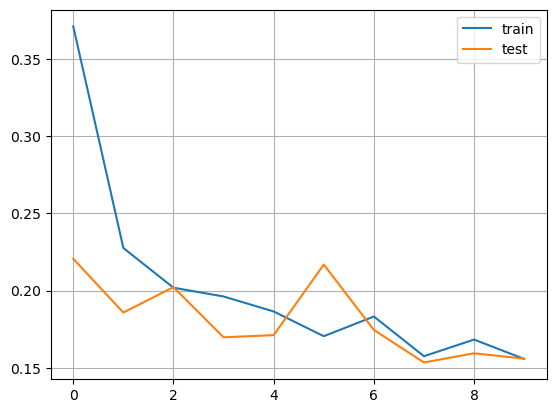

In [15]:
plt.plot(train_sc, label='train')
plt.plot(test_sc, label='test')
plt.grid()
plt.legend()

In [16]:
def gradient_penalty(critic, real_data, fake_data, device="cpu"):
    batch_size = real_data.size(0)
    # Generate random interpolation between real and fake data
    alpha = torch.rand(batch_size, 1, device=device)
    alpha = alpha.expand_as(real_data)
    interpolated = alpha * real_data + (1 - alpha) * fake_data
    interpolated = interpolated.requires_grad_(True)

    # Calculate critic scores on interpolated data
    critic_interpolated = critic(interpolated)

    # Calculate gradients of critic scores with respect to interpolated data
    gradients = torch.autograd.grad(
        outputs=critic_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(critic_interpolated),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Calculate gradient penalty
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()
    return gradient_penalty

## Hyperparameter Tuning

In [47]:
#modeltype = MLP
modeltype = mingruinspred.Mingrustack

In [48]:
def tune_training(config, modeltype):
    tunemodel = modeltype(config['depth'], xdim, config['nhidden'], config['dropout']).to(device)
    total_params = sum(p.numel() for p in tunemodel.parameters())
    print(f"Total parameters: {total_params}") 

    train_dataloader = DataLoader(train_dataset, batch_size=config['nbatch'], shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=config['nbatch'], shuffle=False)
    optim = torch.optim.Adam(tunemodel.parameters(), lr=config['lr'])
    crit = torch.nn.BCELoss()
    # main training
    while True: # allow scheduler to stop
        train_loss = 0.0
        #model.train()  # Set the model to training mode
        for batch_idx, (features, labels) in enumerate(train_dataloader):

            # Forward pass
            outputs = tunemodel(features)
            outputs = outputs.squeeze(-1)  # Remove the last dimension for BCELoss

            #shift data and calculate gradient penalty
            features_shift = torch.roll(features, 1, 0)

            #gp = gradient_penalty(tunemodel, features, features_shift)
 
            # Calculate loss
            loss = crit(outputs, labels)

            # Backward pass and optimization
            optim.zero_grad()
            loss.backward()
            optim.step()

            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_dataloader)

        test_loss = 0.0
        #model.eval()
        with torch.no_grad():
            for batch_idx, (features, labels) in enumerate(test_dataloader):

                # Forward pass
                outputs = tunemodel(features)
                outputs = outputs.squeeze(-1)  # Remove the last dimension for BCELoss

                # Calculate loss
                loss = crit(outputs, labels)

                test_loss += loss.item()
        avg_test_loss = test_loss / len(test_dataloader)
        #print(f"Epoch [{epoch+1}/{num_epochs}], "
        #      f"Train Loss: {avg_train_loss:.4f}, "
        #      f"Test Loss: {avg_test_loss:.4f}")
        
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            #print(temp_checkpoint_dir)
            path = pathlib.Path(temp_checkpoint_dir, "checkpoint.pt")
            torch.save(
                (tunemodel.state_dict(), optim.state_dict()), path
            )
            checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
            train.report(
                {"test_loss": avg_test_loss},
                checkpoint=checkpoint,
            )
        
    pass

In [49]:
search_space = {
    'lr': tune.qloguniform(1e-4, 1e-2, 1e-5),
    'nhidden': tune.randint(10, 128),
    'depth': tune.randint(1, 2),
    'nbatch': tune.choice([8, 16, 32, 64]),
    'dropout': tune.uniform(0.0, 0.5)
}

scheduler = ASHAScheduler(
    metric='test_loss',
    mode="min",
    max_t=100,
    grace_period=20,
)

schedmed = MedianStoppingRule(
    metric='test_loss',
    min_samples_required=5,
    mode="min",
    grace_period=100)


tuneconfig = tune.TuneConfig(
    num_samples=10,
    max_concurrent_trials=10,
    scheduler=scheduler,
)

In [50]:

trainerwithres =   tune.with_resources(tune_training, {'cpu':1})
trainerwithparam = tune.with_parameters(trainerwithres, modeltype=modeltype)
tuner = tune.Tuner(
    trainerwithparam,
    tune_config=tuneconfig,
    run_config=train.RunConfig(
        storage_path=pathlib.Path(".").resolve().as_uri(), # this combination works on windows
        #name=expname,
        checkpoint_config=train.CheckpointConfig(
            # We'll keep the best five checkpoints at all times
            checkpoint_score_attribute="test_loss",
            checkpoint_score_order="min",
            num_to_keep=5,
        ),
    ),
    param_space= search_space   
    )


In [51]:
import os

os.environ["TUNE_DISABLE_AUTO_CALLBACK_LOGGERS"] = "0"

In [52]:
# Run trials
results = tuner.fit()

2024-12-29 16:05:05,387	WARNING trial.py:647 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\Alesi\AppData\Local\Temp\ray\session_2024-12-29_15-49-27_446798_14908\artifacts\2024-12-29_16-05-05\tune_training_2024-12-29_16-05-05\driver_artifacts\tune_training_3b1d2_00000_0_depth=1,dropout=0.2686,lr=0.0001,nbatch=32,nhidden=53_2024-12-29_16-05-05
2024-12-29 16:05:05,393	WARNING trial.py:647 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\Alesi\AppData\Local\Temp\ray\session_2024-12-29_15-49-27_446798_14908\artifacts\2024-12-29_16-05-05\tune_training_2024-12-29_16-05-05\driver_artifacts\tune_training_3b1d2_00000_0_depth=1,dropout=0.2686,lr=0.0001,nbatch=32,nhidden=53_2024-12-29_16-05-05
2024-12-29 16:05:05,397	WARNING trial.py:647 -- The path to the trial log directory is too long (max length: 260. Co

(tune_training pid=3560) Total parameters: 1189


2024-12-29 16:05:11,948	WARNING trial.py:647 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\Alesi\AppData\Local\Temp\ray\session_2024-12-29_15-49-27_446798_14908\artifacts\2024-12-29_16-05-05\tune_training_2024-12-29_16-05-05\driver_artifacts\tune_training_3b1d2_00003_3_depth=1,dropout=0.2234,lr=0.0002,nbatch=64,nhidden=108_2024-12-29_16-05-05
2024-12-29 16:05:11,976	WARNING trial.py:647 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\Alesi\AppData\Local\Temp\ray\session_2024-12-29_15-49-27_446798_14908\artifacts\2024-12-29_16-05-05\tune_training_2024-12-29_16-05-05\driver_artifacts\tune_training_3b1d2_00000_0_depth=1,dropout=0.2686,lr=0.0001,nbatch=32,nhidden=53_2024-12-29_16-05-05
2024-12-29 16:05:11,983	WARNING trial.py:647 -- The path to the trial log directory is too long (max length: 260. C

In [53]:
# If restoring results from file
restoreresults = False
if restoreresults:
    expname = 'tune_training_2024-12-23_18-35-34'
    experiment_path = pathlib.Path('.').joinpath(expname).resolve().as_uri() ## must 
    if tune.Tuner.can_restore(experiment_path):
        restored_tuner = tune.Tuner.restore(experiment_path, trainerwithparam)
        results = restored_tuner.get_results()
    else:
        print('failed to restore')

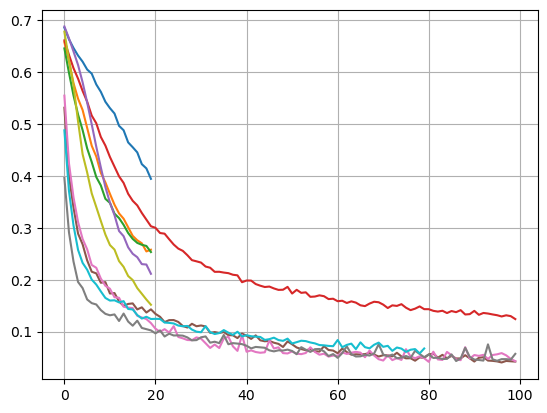

In [54]:
# plot different trials
#%matplotlib ipympl
dfs = {result.path: result.metrics_dataframe for result in results}
[d.test_loss.plot() for d in dfs.values()]
plt.grid()

## Tuned model

### Get best check point

In [55]:
bestresult = results.get_best_result(metric="test_loss", mode="min", scope='all')

In [56]:
bestconfig = bestresult.config
print(bestconfig)
# this only gets the last path
# it may not be the best when over trained
print(bestresult.checkpoint.path)

{'lr': 0.0018000000000000002, 'nhidden': 38, 'depth': 1, 'nbatch': 32, 'dropout': 0.40751856654671653}
C:/Users/Alesi/work/minGRU-pytorch/tune_training_2024-12-29_16-05-05/tune_training_3b1d2_00005_5_depth=1,dropout=0.4075,lr=0.0018,nbatch=32,nhidden=38_2024-12-29_16-05-05/checkpoint_000099


In [57]:
bestresult.metrics['test_loss'] # last checkpoint, not the best

0.04229721362965502

In [58]:
bestresult

Result(
  metrics={'test_loss': 0.04229721362965502},
  path='C:/Users/Alesi/work/minGRU-pytorch/tune_training_2024-12-29_16-05-05/tune_training_3b1d2_00005_5_depth=1,dropout=0.4075,lr=0.0018,nbatch=32,nhidden=38_2024-12-29_16-05-05',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=C:/Users/Alesi/work/minGRU-pytorch/tune_training_2024-12-29_16-05-05/tune_training_3b1d2_00005_5_depth=1,dropout=0.4075,lr=0.0018,nbatch=32,nhidden=38_2024-12-29_16-05-05/checkpoint_000099)
)

In [59]:
with bestresult.get_best_checkpoint('test_loss', 'min').as_directory() as checkpoint_dir:
    state_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))

In [60]:
bestmodel = modeltype(bestconfig['depth'], xdim, bestconfig['nhidden'])
bestmodel.load_state_dict(state_dict[0])

<All keys matched successfully>

### Summary of the best model

In [61]:
sum(p.numel() for p in bestmodel.parameters())

419


(process:28192): Pango-WARNING **: 16:06:55.156: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


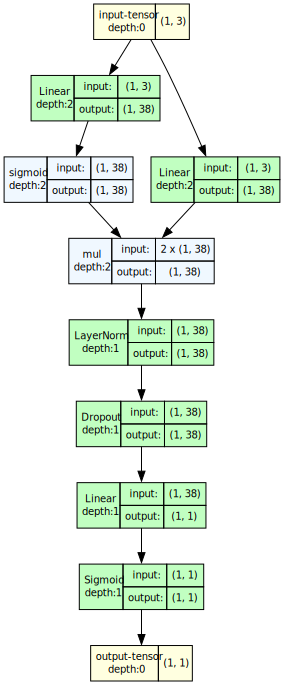

In [62]:
graph = draw_graph(bestmodel, input_size=(1, xdim),  device=device)

graph.visual_graph

### Output performace

In [63]:
outputslist = []
labelslist = []
featureslist = []
with torch.no_grad():
    for batch_idx, (features, labels) in enumerate(test_dataloader):
        outputs = bestmodel(features)
        featureslist.append(features)
        outputslist.append(outputs)
        labelslist.append(labels)

labels_torch = torch.cat(labelslist)
outputs_torch = torch.cat(outputslist).squeeze(-1)

In [64]:
features_torch = torch.cat(featureslist)

In [65]:
b = BinaryAUROC()
b(outputs_torch, labels_torch)

tensor(0.9995)

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:ylabel='BinaryAUROC'>)

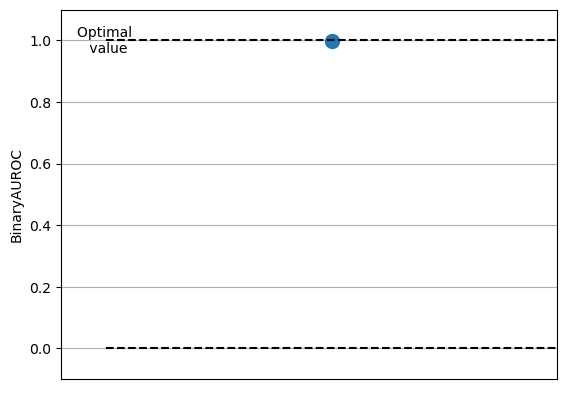

In [66]:
b.plot()

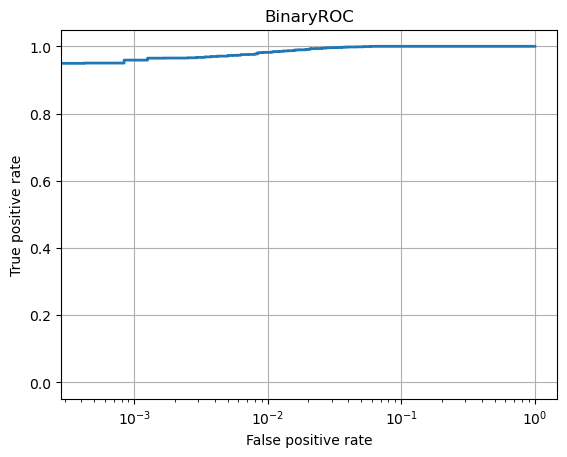

In [67]:
fig, ax = plt.subplots()
roc = ROC(task='binary')
fpr, tpr, thresh = roc(outputs_torch, labels_torch.int())
ax.set_xscale('log')
roc.plot(ax=ax)
plt.show()

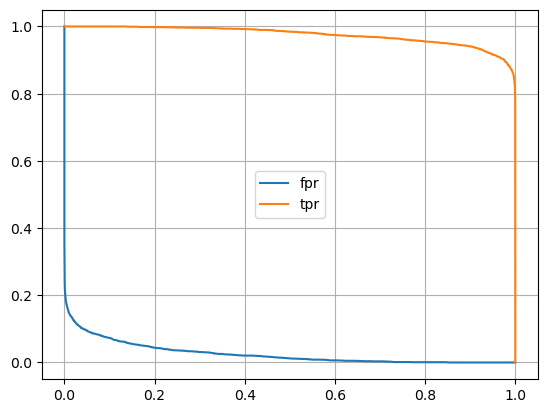

In [68]:
plt.clf()
plt.plot(thresh, fpr, '-', label='fpr')
plt.plot(thresh, tpr, '-', label='tpr')
plt.legend()
plt.grid()
plt.show()

In [69]:
acc = BinaryAccuracy()
acc(outputs_torch, labels_torch)

tensor(0.9860)

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:ylabel='BinaryAccuracy'>)

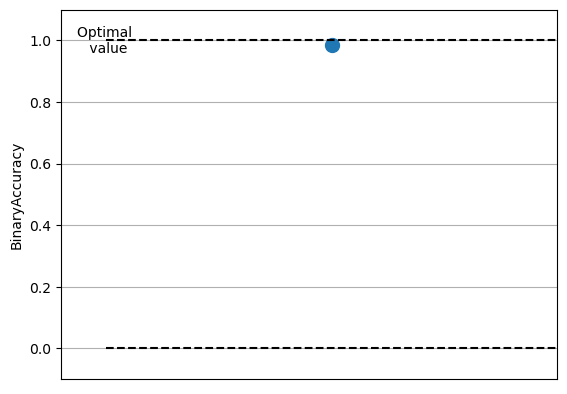

In [70]:
acc.plot()

In [71]:
features_torch=torch.cat(featureslist)

In [72]:
featuresr = torch.sqrt(torch.sum(features_torch.square(), dim=1))

In [73]:
testoutput =pd.DataFrame({'r': featuresr.numpy(), 'label': labels_torch.numpy(), 'output':outputs_torch.numpy()})

In [74]:
testoutput

,r,label,output
0,2.027805,0.0,3.800209e-07
1,1.461132,1.0,1.000000e+00
2,1.742603,0.0,3.147119e-01
3,2.040255,0.0,5.255237e-08
4,1.406844,1.0,1.000000e+00
...,...,...,...
4995,1.185124,1.0,1.000000e+00
4996,1.571738,1.0,9.995961e-01
4997,2.308933,0.0,8.518133e-14
4998,1.218039,1.0,1.000000e+00


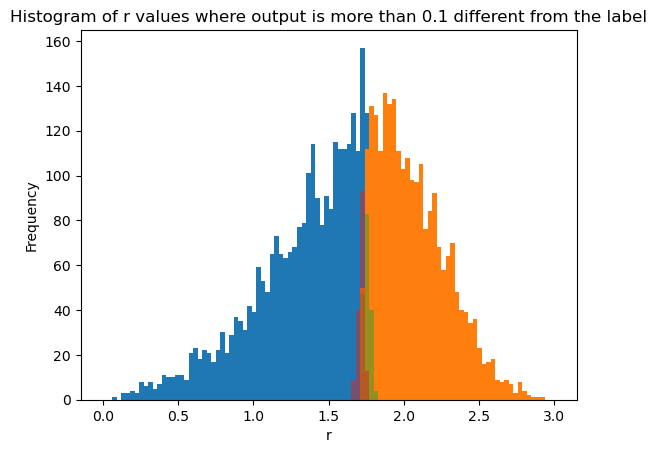

In [75]:
# Filter the data where the absolute difference between output and label is greater than 0.01
filtered_data = testoutput[testoutput['label'] == 0]
filtered_data2 = testoutput[(testoutput['label'] == 0) & (abs(testoutput['output'] - testoutput['label']) > 0.1)]
filtered_data3 = testoutput[(testoutput['label'] == 1) & (abs(testoutput['output'] - testoutput['label']) > 0.1)]
# Plot the histogram of 'r' values
plt.clf()
plt.hist(testoutput['r'], bins=100, range=(0.0, 3.0))
plt.hist(filtered_data['r'], bins=100, range=(0.0, 3.0))
plt.hist(filtered_data2['r'], bins=100, range=(0.0, 3.0), alpha=0.5)
plt.hist(filtered_data3['r'], bins=100, range=(0.0, 3.0), alpha=0.5)
plt.xlabel('r')
plt.ylabel('Frequency')
plt.title('Histogram of r values where output is more than 0.1 different from the label')
plt.show()

In [76]:
print(filtered_data2.shape[0])
print(filtered_data3.shape[0])

174
155
